In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import altair as alt
import pycountry

from vega_datasets import data
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [2]:
df = pd.read_excel('../data/eurovision_song_contest.xlsx')

In [3]:
# Clean column names

df = df.rename(str.lower, axis='columns')
df = df.rename(columns={'(semi-) final': 'semi_final',
                        'jury or televoting': 'jury_televoting',
                        'from country': 'from_country',
                        'to country': 'to_country',
                        'points      ': 'points'})

In [4]:
# Drop rows where `from_country` and `to_country` are the same
# Only include votes from the jury at the finals

df = df[(df['duplicate'] != 'x') & 
        (df['semi_final'] == 'f') &
        (df['jury_televoting'] == 'J')]
df = df.drop(columns='duplicate')

In [5]:
df.head()

,year,semi_final,edition,jury_televoting,from_country,to_country,points
1,1975,f,1975f,J,Belgium,Finland,0
2,1975,f,1975f,J,Belgium,France,2
3,1975,f,1975f,J,Belgium,Germany,0
4,1975,f,1975f,J,Belgium,Ireland,12
5,1975,f,1975f,J,Belgium,Israel,1


In [6]:
df['from_country'] = df.from_country.str.replace('F.Y.R. Macedonia', 'North Macedonia', regex=False)
df['to_country'] = df.to_country.str.replace('F.Y.R. Macedonia', 'North Macedonia', regex=False)

In [7]:
df['to_country_year'] = df['to_country'] + df.year.map(str)

In [8]:
# Check for duplicate entries
df[df.duplicated(['from_country', 'to_country_year'])]

,year,semi_final,edition,jury_televoting,from_country,to_country,points,to_country_year
49831,2019,f,2019f,J,Belarus,Russia,1,Russia2019


In [9]:
df.query("from_country == 'Belarus' and to_country_year == 'Russia2019'")

,year,semi_final,edition,jury_televoting,from_country,to_country,points,to_country_year
49810,2019,f,2019f,J,Belarus,Russia,0,Russia2019
49831,2019,f,2019f,J,Belarus,Russia,1,Russia2019


According to [this scoreboard](https://eurovisionworld.com/eurovision/2019), Belarus gave Russia 1 point that year.

In [10]:
# Keep the correct observation

df = df[~(df['from_country'] == 'Belarus') |
        ~(df['to_country_year'] == 'Russia2019') |
        ~(df['points'] == 0)]

In [11]:
# Drop observations from before 2000
df = df.query('year > 1999')

In [12]:
test = df.loc[:, ['from_country', 'points', 'to_country_year']]

In [13]:
test = test.pivot(index='from_country', columns='to_country_year', values='points')

In [14]:
# Fill in missing values
for country in test.index:
    row = test.loc[country, :]
    for i in range(len(row)):
        # if entry has a NaN
        if np.isnan(row[i]):
            # if it's missing for itself
            if country in row.index[i]:
                row[i] = 12
            # if it's missing for another country
            else:
                row[i] = 0

In [15]:
test.isna().sum().sum()

0

In [16]:
# Code attribution: Rodolfo Lourenzutti
def plot_dendrogram(data, method, metric, w=20, h=10):
    Z = linkage(data, method=method, metric=metric)
    fig, ax = plt.subplots(figsize=(w,h))
    dendrogram(Z, labels=data.index, ax=ax)
    ax = plt.gca()
    ax.set_ylabel("Euclidean distance", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, fontsize=18)

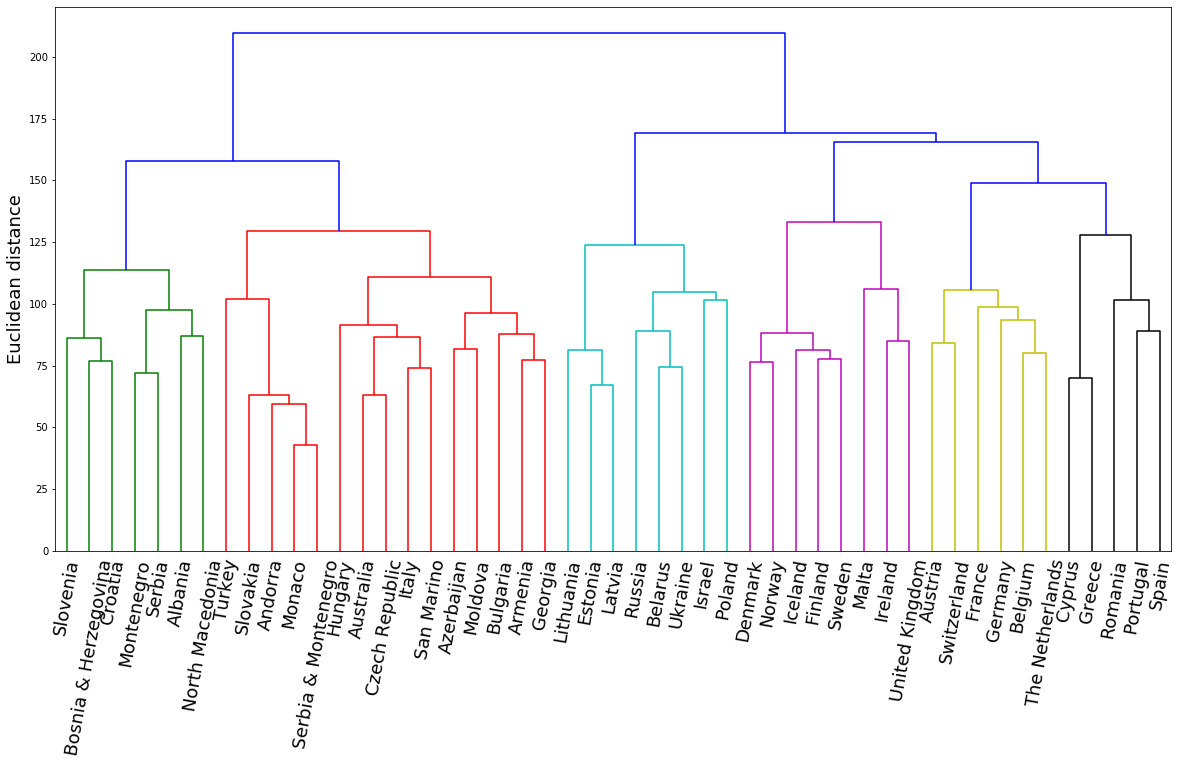

In [17]:
plot_dendrogram(test, 'ward', 'euclidean')

In [18]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
label = cluster.fit_predict(test)

In [19]:
# https://stackoverflow.com/questions/61135952/vega-lite-altair-how-to-center-or-crop-a-map-of-europe
countries = alt.topo_feature(data.world_110m.url, 'countries')
countries

UrlData({
  format: TopoDataFormat({
    feature: 'countries',
    type: 'topojson'
  }),
  url: 'https://vega.github.io/vega-datasets/data/world-110m.json'
})

In [36]:
codes = []
for i in range(5):
    codes.append(pycountry.countries.search_fuzzy(test.index[i])[0].numeric)

In [46]:
test_dict = {'country': test.index[:5].to_list(), 'id': codes, 'label': label[:5]}
tes_df = pd.DataFrame(test_dict)